# Functions

In [18]:
import pandas as pd 
import wandb
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import sys
api = wandb.Api()
import seaborn as sns
import scipy
import pickle
import os

In [11]:
def return_list(run, metric):
    return run.history(keys=[metric]).to_numpy()[:,1]

def get_stat(entity, project):
    #entity, project = "inouye-lab", "[ZZ]425-test"  # set to your entity and project 
    runs = api.runs(entity + "/" + project)
#    summary_list, config_list, name_list = [], [], []
    val_list, test_list = [], []
    tracker = []
    for run in runs: 
        config = pd.DataFrame([run.config])
        #val_align = pd.DataFrame({'val_align':[return_list(run,"Loss/val_GF_align")]})
        val_align = pd.DataFrame({'val_align':[return_list(run,"Loss/test_GF_align")]})
        test = pd.DataFrame({'test_cf':[return_list(run,"test_counterfactual_error/d_neq_dp_avg")]})
        name = pd.DataFrame({'name':[run.name]})
        config = pd.concat([name,config,val_align,test],axis=1)
        tracker.append(config)
    tracker = pd.concat(tracker)
    return tracker

In [12]:
def find_rows(df, specs):
    for spec_name, spec in specs.items():
        df = df.loc[df[spec_name]==spec]
    return df

def best_test_val(df):
    seeds = []
    error = []
    for _, row in df.iterrows():
        val_align = row['val_align']
        #assert len(val_align) == 500, 'not finished'
        test_cf = row['test_cf']
        
        idx = np.argmin(val_align)
        #idx = np.argmin(test_cf) 
        
        best_error = test_cf[idx]
        #best_error = val_align[idx]
        seed = row['seed']
        error.append(best_error)
        seeds.append(seed)
    error = error
    res = pd.DataFrame([error],columns=seeds)  
    
    res.insert(0,'std',np.std(error))
    res.insert(0,f'ste({len(seeds)})',np.std(error)/np.sqrt(len(seeds)))
    res.insert(0,'ste',np.std(error)/np.sqrt(len(seeds)))
    res.insert(0,'mean',np.mean(error))
    #res['std'] = np.std(error)
    return res

def find_best(df, specs, candidates):
    #assert len(val_err[run_name]) == 5
    #assert len(test_err[run_name]) == 5
    df = find_rows(df, specs)
    
    all_res = []
    
    for candidate in candidates:
        df_temp = df[df['f_type'] == candidate]
        res = best_test_val(df_temp)
        res.insert(0, 'model', candidate)
        all_res.append(res)
        #display(res)
    all_res = pd.concat(all_res)
    all_res = all_res.sort_values('mean')
    all_res.set_index('model', inplace=True)
    all_res = all_res.round(3)
    return all_res

def find_id(df, specs):
    df = find_rows(df, specs)
    df = df[df['f_type'] == 'auto_full']
    seeds = []
    error = []
    for _, row in df.iterrows():
        seeds.append(row['seed'])
        error.append(row['id'][0])
        
    return np.mean(error), np.std(error)/np.sqrt(len(seeds))

# Preparation

In [24]:
plt.rcParams.update({'font.size': 40})
sns.set_theme()
#sns.set({'font.size': 60})
sns.set(font_scale=1.5)

In [19]:
names = dict()
names['dense'] = 'ILD-Dense'
names['relax_can'] = 'ILD-Relax-Can'

nt_nd = '$N_d$'
nt_dim = 'm'
def nt_int(int_set):
    int_set = int_set.split(',')
    int_set = [int(i)+1 for i in int_set]
    int_set = ','.join(map(str, int_set))
    return int_set
rot = 0

# TODO: replace with your own directory
global_save_dir = './results/'
if not os.path.exists(global_save_dir):
    os.makedirs(global_save_dir)

In [15]:
# TODO: Replace with your own wandb entity and project name

entity, project = "inouye-lab", "ICLR24-CameraReady-Simulated1"
stats = get_stat(entity, project)

In [21]:
with open(f'{global_save_dir}simulated.pkl', 'wb') as file:
    pickle.dump(stats, file)

In [22]:
with open(f'{global_save_dir}simulated.pkl', 'rb') as f:
    stats = pickle.load(f)


In [25]:
def gen_bar_plot(means,stes,candidates,nums,title=None,ticks=None,save_dir=None,ticks_rot=None,ylim=None, legend=True):
    colors = ['r','g','b','y','k']
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    X = np.arange(nums)
    for i,_ in enumerate(candidates):
        ax.bar(X+0.2*i,means[:,i],yerr=stes[:,i],color=colors[i],align='center',label=names[candidates[i]],width=0.2)
    if ticks:
        if not ticks_rot:
            ax.set_xticks(X+0.1, ticks)
        else:
            ax.set_xticks(X+0.1, ticks,rotation=ticks_rot)
    ax.set_ylabel('c.f. error')
    if legend:
        plt.legend(frameon=False)
    #legend.get_frame().set_alpha(None)
    if title:
        plt.title(title)
    if ylim:
        plt.ylim(ylim)

#    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9)
    plt.tight_layout()
    if save_dir:
        plt.savefig(global_save_dir+save_dir,dpi=300)

    plt.show()


# Main Papper

### Case 1: Different indices

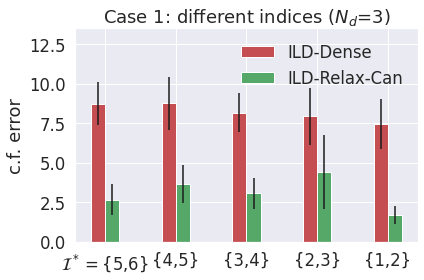

In [35]:
intsets = ['4,5','3,4','2,3','1,2','0,1']
candidates = ['dense','relax_can']
latent_dim = 6
ndomain = 3
k_spa = 2


for intset in intsets:
    #print(f'Intset = {intset}')
    specs = {}
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best(stats,specs,candidates)
    #display(df)

means = np.zeros((len(intsets),len(candidates)))
stes = np.zeros((len(intsets),len(candidates)))

for idx,intset in enumerate(intsets):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa
    
        df = find_best(stats,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste']
        #stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot(means,stes,candidates,len(intsets),
             ticks=[f'$\mathcal{{I}}^*=${{{nt_int(intset)}}}' for intset in [intsets[0]]]+[f'{{{nt_int(intset)}}}' for intset in intsets[1:]],
             #title=f'$\mathcal{{I}}$ ({nt_dim}={latent_dim}, {nt_nd}={ndomain})',
             title=f'Case 1: different indices ({nt_nd}={ndomain})',
             ticks_rot=rot ,
             ylim = (0,13.5),
            save_dir=f'intpos_ndomain{ndomain}')


### Case 2: Int set size

Intset = 4,5


/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,mean,ste,ste(0),std
model,,,,
dense,NaN,NaN,NaN,NaN
relax_can,NaN,NaN,NaN,NaN


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,1,2,0
model,,,,,,,,,,,,,,
relax_can,2.654,0.981,0.981,3.102,0.579,0.679,2.033,7.455,0.190,2.250,0.371,3.364,0.156,9.467
dense,8.740,1.372,1.372,4.340,11.520,12.264,5.584,19.019,9.178,4.249,6.120,7.598,3.903,7.962


Intset = 4,5


/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,mean,ste,ste(0),std
model,,,,
dense,NaN,NaN,NaN,NaN
relax_can,NaN,NaN,NaN,NaN


Intset = 4,5


/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,mean,ste,ste(0),std
model,,,,
dense,NaN,NaN,NaN,NaN
relax_can,NaN,NaN,NaN,NaN


/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


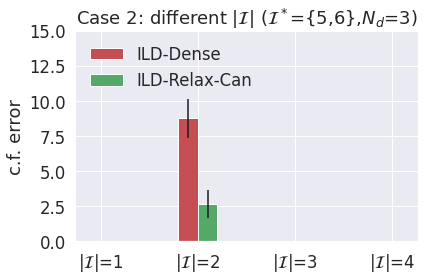

In [36]:

intset = '4,5'
candidates = ['dense','relax_can']
latent_dim = 6
ndomain = 3
k_spas = [1,2,3,4]


for k_spa in k_spas:
    print(f'Intset = {intset}')
    specs = {}
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best(stats,specs,candidates)
    display(df)

means = np.zeros((len(k_spas),len(candidates)))
stes = np.zeros((len(k_spas),len(candidates)))

for idx,k_spa in enumerate(k_spas):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa
    
        df = find_best(stats,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste']
        #stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot(means,stes,candidates,len(k_spas),
             ticks=[f'$|\mathcal{{I}}|$={k_spa}' for k_spa in k_spas],
             title=f'Case 2: different $|\mathcal{{I}}|$ ($\mathcal{{I}}^*$={{5,6}},{nt_nd}={ndomain})',
             ticks_rot=rot ,
             ylim = (0,15),
            save_dir=f'intsizek_ndomain{ndomain}')


# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(5)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ['I={}'.format(intset) for intset in intsets])
# plt.show()

# Appendix

In [109]:
# entity, project = "inouye-lab", "[Neurips2023]Simulated-app"
# stats_app = get_stat(entity, project)
# stats_all = pd.concat([stats,stats_app])

In [110]:
# entity, project = "inouye-lab", "[Neurips2023]Simulated-extra"
# stats_extra = get_stat(entity, project)

In [19]:
global_save_dir = '/local/scratch/a/zhou1059/latentcausal/simulated/ICLR/results_app/'
def gen_bar_plot(means,stes,candidates,nums,title=None,ticks=None,save_dir=None,ticks_rot=None,ylim=None, legend=True):
    colors = ['r','g','b','y','k']
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    X = np.arange(nums)
    for i,_ in enumerate(candidates):
        ax.bar(X+0.2*i,means[:,i],yerr=stes[:,i],color=colors[i],align='center',label=names[candidates[i]],width=0.2)
    if ticks:
        if not ticks_rot:
            ax.set_xticks(X+0.1, ticks)
        else:
            ax.set_xticks(X+0.1, ticks,rotation=ticks_rot)
    ax.set_ylabel('c.f. error')
    if legend:
        plt.legend(frameon=False)
    #legend.get_frame().set_alpha(None)
    if title:
        plt.title(title)
    if ylim:
        plt.ylim(ylim)

#    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9)
    plt.tight_layout()
    if save_dir:
        plt.savefig(global_save_dir+save_dir,dpi=300)

    plt.show()


In [20]:
plt.rcParams.update({'font.size': 40})
sns.set_theme()
#sns.set({'font.size': 60})
sns.set(font_scale=1.5)

In [21]:
column_name = ['mean', 'ste', 'ste(10)', 'std', 0,1,2,3,4,5,6,7,8,9]

## Case 1: No misspecification

### Number of domains

number of domains = 2


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,2.920,0.949,0.949,3.002,0.454,4.141,0.461,5.115,10.360,2.405,0.391,0.329,3.983,1.562
auto_full,7.246,1.228,1.228,3.885,4.137,12.677,8.121,14.286,5.909,3.737,3.971,1.968,7.455,10.196


number of domains = 3


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,2.635,0.968,0.968,3.062,0.594,0.692,2.079,7.209,0.188,2.235,0.370,0.159,3.361,9.466
auto_full,8.725,1.359,1.359,4.299,11.467,12.357,5.558,18.821,9.238,4.246,6.106,3.924,7.573,7.962


number of domains = 5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,2.039,0.750,0.750,2.372,0.603,0.607,3.211,6.208,0.163,1.284,0.591,6.758,0.69,0.273
auto_full,6.796,0.912,0.912,2.885,9.945,10.281,3.162,11.112,8.794,3.198,4.208,4.502,6.57,6.192


number of domains = 10


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,1.566,0.866,0.866,2.740,0.539,0.746,0.266,9.162,0.315,0.328,3.795,0.171,0.140,0.193
auto_full,7.115,0.865,0.865,2.734,9.234,11.064,4.535,12.342,7.540,3.636,5.546,5.253,6.074,5.926


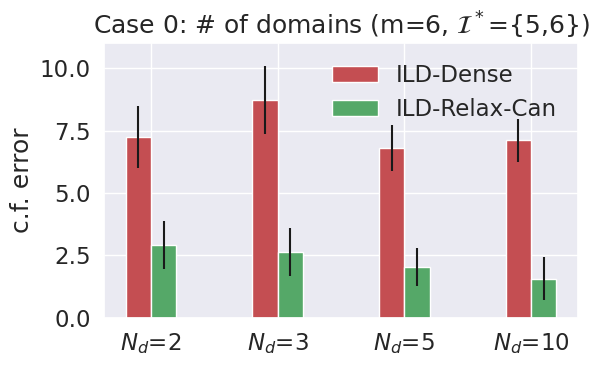

In [28]:
nds = [2,3,5,10]
#nds = [2,3,5]
#candidates = ['auto_full','auto_true_spa','auto_spa_can']
candidates = ['auto_full','auto_true_spa']

scm_idx = '1bl'
latent_dim = 6
int_set = '4,5'
k_spa = 2


for nd in nds:
    print(f'number of domains = {nd}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = nd
    specs['int_set'] = int_set
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best(stats,specs,candidates)
    display(df)

means = np.zeros((len(nds),len(candidates)))
stes = np.zeros((len(nds),len(candidates)))

for idx,nd in enumerate(nds):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = nd
        specs['int_set'] = int_set
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa

        df = find_best(stats,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste(10)']
        
        
gen_bar_plot(means,stes,candidates,len(nds),
           ticks= (f'{nt_nd}=2', f'{nt_nd}=3',f'{nt_nd}=5',f'{nt_nd}=10'),
             #ticks= (f'{nt_nd}=2', f'{nt_nd}=3',f'{nt_nd}=5'),
             title=f'Case 0: # of domains ({nt_dim}=6, $\mathcal{{I}}^*$={{5,6}})',
             ticks_rot=rot ,
             ylim=(0,11),
            save_dir='ndomains_m6',
            legend=True)


# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(5)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, (f'{nt_nd}=2', f'{nt_nd}=3',f'{nt_nd}=5', f'{nt_nd}=8',f'{nt_nd}=10'))
# plt.show()

### Higher dimension

dim = 4


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_full,4.253,0.595,0.595,1.881,3.321,3.435,2.838,4.209,5.356,6.456,1.615,2.165,5.195,7.937
auto_true_spa,4.385,2.114,2.114,6.684,23.790,2.309,1.747,3.180,1.265,0.864,0.779,0.227,3.325,6.362


dim = 6


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_true_spa,2.920,0.949,0.949,3.002,1.562,3.983,0.329,0.391,2.405,10.360,5.115,0.461,4.141,0.454
auto_full,7.246,1.228,1.228,3.885,10.196,7.455,1.968,3.971,3.737,5.909,14.286,8.121,12.677,4.137


dim = 8


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_true_spa,1.669,0.463,0.463,1.463,0.136,4.242,0.094,2.458,1.335,0.135,1.913,3.383,2.879,0.116
auto_full,7.143,1.751,1.751,5.538,5.792,1.997,4.110,1.358,9.579,5.276,7.019,6.020,22.109,8.165


dim = 10


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_true_spa,3.187,1.091,1.091,3.451,4.625,0.111,0.120,0.072,4.572,10.617,4.360,6.809,0.099,0.479
auto_full,3.719,0.619,0.619,1.957,2.382,3.249,1.051,2.282,3.459,2.025,6.551,4.144,7.658,4.388


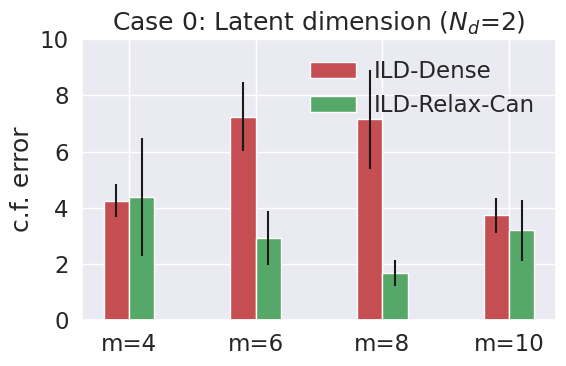

In [31]:
ndims = [4,6,8,10]
intsets = ['2,3','4,5','6,7','8,9']
#candidates = ['auto_full','auto_true_spa','auto_spa_can']
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
ndomain = 2
k_spa = 2


for nd,intset in zip(ndims,intsets):
    print(f'dim = {nd}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = nd
    specs['k_spa'] = k_spa

    df = find_best(stats_all,specs,candidates)
    df = df[column_name]
    display(df)

means = np.zeros((len(ndims),len(candidates)))
stes = np.zeros((len(ndims),len(candidates)))

for idx,(nd,intset) in enumerate(zip(ndims,intsets)):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = nd
        specs['k_spa'] = k_spa

        df = find_best(stats_all,specs,[label])

        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot(means,stes,candidates,len(ndims),
             ticks=(f'{nt_dim}=4', f'{nt_dim}=6', f'{nt_dim}=8', f'{nt_dim}=10'),
             title=f'Case 0: Latent dimension ({nt_nd}={ndomain})',
             ticks_rot=rot ,
             ylim=(0,10),
            save_dir=f'ndim_ndomain{ndomain}')

# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(4)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ('d=4', 'd=6','d=8','d=10'))
# plt.show()

dim = 4


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_true_spa,4.958,2.092,2.092,6.614,23.821,0.611,2.178,5.823,4.779,0.694,0.487,1.653,3.170,6.365
auto_full,6.431,1.930,1.930,6.103,24.472,3.658,2.925,5.785,3.260,5.795,3.878,4.560,4.009,5.965


dim = 6


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_true_spa,2.635,0.968,0.968,3.062,9.466,3.361,0.159,0.370,2.235,0.188,7.209,2.079,0.692,0.594
auto_full,8.725,1.359,1.359,4.299,7.962,7.573,3.924,6.106,4.246,9.238,18.821,5.558,12.357,11.467


dim = 8


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_true_spa,2.684,1.123,1.123,3.55,4.602,2.510,0.240,0.156,0.185,0.427,7.309,0.280,10.804,0.330
auto_full,5.851,1.531,1.531,4.84,3.025,3.958,5.371,2.763,5.290,2.652,9.083,3.999,19.298,3.073


dim = 10


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_true_spa,2.600,0.907,0.907,2.869,9.185,0.038,0.679,3.119,0.044,0.849,1.061,4.835,0.758,5.436
auto_full,5.438,0.740,0.740,2.340,11.056,4.348,2.993,4.164,3.039,4.114,5.147,5.884,5.628,8.005


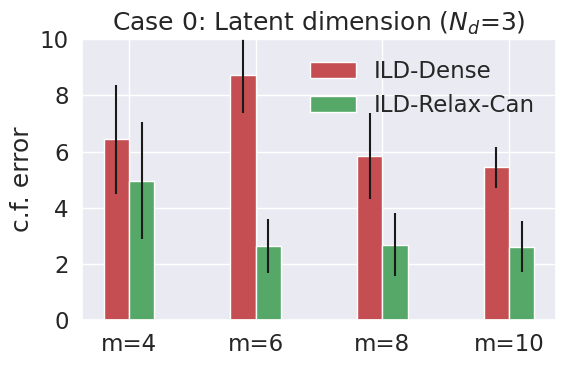

In [33]:
ndims = [4,6,8,10]
intsets = ['2,3','4,5','6,7','8,9']
#candidates = ['auto_full','auto_true_spa','auto_spa_can']
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
ndomain = 3
k_spa = 2


for nd,intset in zip(ndims,intsets):
    print(f'dim = {nd}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = nd
    specs['k_spa'] = k_spa

    df = find_best(stats_all,specs,candidates)
    df = df[column_name]
    display(df)

means = np.zeros((len(ndims),len(candidates)))
stes = np.zeros((len(ndims),len(candidates)))

for idx,(nd,intset) in enumerate(zip(ndims,intsets)):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = nd
        specs['k_spa'] = k_spa

        df = find_best(stats_all,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot(means,stes,candidates,len(ndims),
             ticks=(f'{nt_dim}=4', f'{nt_dim}=6', f'{nt_dim}=8', f'{nt_dim}=10'),
             title=f'Case 0: Latent dimension ({nt_nd}={ndomain})',
             ticks_rot=rot ,
             ylim=(0,10),
            save_dir=f'ndim_ndomain{ndomain}')

# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(4)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ('d=4', 'd=6','d=8','d=10'))
# plt.show()

dim = 4


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,1.219,0.518,0.518,1.637,6.051,0.163,0.821,0.265,0.561,1.146,0.543,0.721,0.948,0.969
auto_full,6.361,1.635,1.635,5.171,9.682,2.630,7.100,4.075,4.303,3.867,3.863,2.401,5.094,20.599


dim = 6


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,1.566,0.866,0.866,2.740,0.539,0.746,0.266,9.162,0.315,0.328,3.795,0.171,0.140,0.193
auto_full,7.115,0.865,0.865,2.734,9.234,11.064,4.535,12.342,7.540,3.636,5.546,5.253,6.074,5.926


dim = 8


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,2.378,0.559,0.559,1.768,0.097,3.473,0.303,1.864,6.164,3.905,2.211,2.969,2.212,0.579
auto_full,5.944,1.301,1.301,4.114,4.665,17.733,4.823,7.419,4.678,5.876,3.086,3.666,3.224,4.268


dim = 10


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,1.578,0.444,0.444,1.404,0.038,0.042,0.17,4.125,3.086,2.976,1.579,1.823,0.108,1.828
auto_full,5.129,0.402,0.402,1.272,6.427,6.382,4.45,5.716,4.452,3.515,3.326,4.819,4.719,7.484


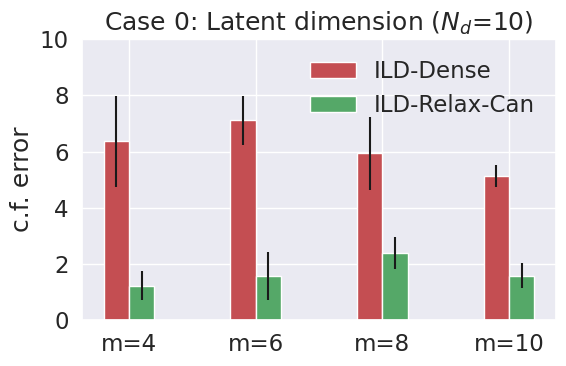

In [34]:
ndims = [4,6,8,10]
intsets = ['2,3','4,5','6,7','8,9']
#candidates = ['auto_full','auto_true_spa','auto_spa_can']
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
ndomain = 10
k_spa = 2


for nd,intset in zip(ndims,intsets):
    print(f'dim = {nd}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = nd
    specs['k_spa'] = k_spa

    df = find_best(stats_all,specs,candidates)
    display(df)

means = np.zeros((len(ndims),len(candidates)))
stes = np.zeros((len(ndims),len(candidates)))

for idx,(nd,intset) in enumerate(zip(ndims,intsets)):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = nd
        specs['k_spa'] = k_spa

        df = find_best(stats_all,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot(means,stes,candidates,len(ndims),
             ticks=(f'{nt_dim}=4', f'{nt_dim}=6', f'{nt_dim}=8', f'{nt_dim}=10'),
             title=f'Case 0: Latent dimension ({nt_nd}={ndomain})',
             ticks_rot=rot ,
             ylim=(0,10),
            save_dir=f'ndim_ndomain{ndomain}')

# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(4)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ('d=4', 'd=6','d=8','d=10'))
# plt.show()

### Different sparsity

Intset = 5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,3.637,1.713,1.713,5.418,17.244,0.409,8.842,2.607,0.230,0.06,6.576,0.039,0.137,0.227
auto_full,11.330,2.814,2.814,8.900,10.181,31.877,5.676,24.079,7.691,6.32,5.685,1.400,9.035,11.357


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,2.920,0.949,0.949,3.002,0.454,4.141,0.461,5.115,10.360,2.405,0.391,0.329,3.983,1.562
auto_full,7.246,1.228,1.228,3.885,4.137,12.677,8.121,14.286,5.909,3.737,3.971,1.968,7.455,10.196


Intset = 3,4,5


,mean,ste,ste(10),std,9,8,6,7,4,5,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,5.07,2.200,2.200,6.956,2.693,4.568,24.070,2.106,2.884,10.777,1.753,0.834,0.871,0.147
auto_full,8.64,1.585,1.585,5.013,9.889,15.842,19.355,8.308,5.075,6.871,4.398,3.102,4.376,9.180


Intset = 2,3,4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,6.244,1.415,1.415,4.476,9.427,14.778,6.406,13.291,5.210,2.847,1.908,3.883,1.974,2.716
auto_full,8.764,2.415,2.415,7.637,10.835,27.875,8.322,16.973,3.505,4.217,3.828,2.347,3.893,5.843


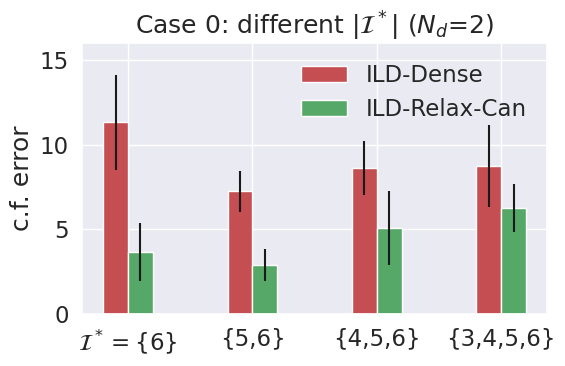

In [35]:
ks = [1,2,3,4]
intsets = ['5','4,5','3,4,5','2,3,4,5']


# ks = [1,3,4]
# intsets = ['5','3,4,5','2,3,4,5']

#candidates = ['auto_full','auto_true_spa','auto_spa_can']
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 6
ndomain = 2


for k,intset in zip(ks,intsets):
    print(f'Intset = {intset}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k

    df = find_best(stats_all,specs,candidates)
    display(df)

means = np.zeros((len(intsets),len(candidates)))
stes = np.zeros((len(intsets),len(candidates)))

for idx,(k,intset) in enumerate(zip(ks,intsets)):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k
    
        df = find_best(stats_all,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste']
        #stes[idx,jdx] = df['ste(10)']

        
gen_bar_plot(means,stes,candidates,len(intsets),
             ticks=[f'$\mathcal{{I}}^*=${{{nt_int(intset)}}}' for intset in [intsets[0]]]+[f'{{{nt_int(intset)}}}' for intset in intsets[1:]],
             title=f'Case 0: different $ |\mathcal{{I}}^*|$ ({nt_nd}={ndomain})',
             ticks_rot=rot ,
             ylim=(0,16),
            save_dir=f'spa_ndomain{ndomain}')



Intset = 5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,0,1
model,,,,,,,,,,,,,,
auto_true_spa,1.899,0.705,0.705,2.229,0.323,0.478,6.273,3.103,0.298,0.087,5.274,0.210,0.035,2.910
auto_full,10.409,2.211,2.211,6.991,11.779,14.634,4.763,29.284,9.440,5.037,4.774,7.368,9.702,7.309


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,2.635,0.968,0.968,3.062,0.594,0.692,2.079,7.209,0.188,2.235,0.370,0.159,3.361,9.466
auto_full,8.725,1.359,1.359,4.299,11.467,12.357,5.558,18.821,9.238,4.246,6.106,3.924,7.573,7.962


Intset = 3,4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,5.457,1.432,1.432,4.528,9.152,10.887,4.939,14.717,4.524,0.547,1.715,0.488,1.967,5.631
auto_full,7.377,1.029,1.029,3.255,7.139,8.750,5.774,15.609,8.915,4.330,4.731,3.835,6.227,8.457


Intset = 2,3,4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,4.646,0.999,0.999,3.160,5.311,10.65,1.350,9.911,4.801,2.902,2.368,3.168,5.112,0.883
auto_full,6.688,0.635,0.635,2.007,6.490,9.37,6.562,10.324,5.302,4.610,3.692,5.528,8.482,6.515


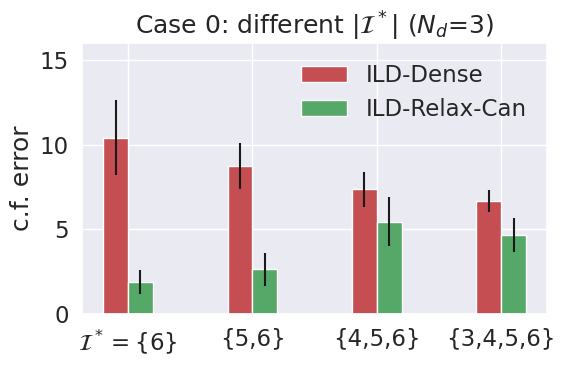

In [36]:
ks = [1,2,3,4]
intsets = ['5','4,5','3,4,5','2,3,4,5']


# ks = [1,3,4]
# intsets = ['5','3,4,5','2,3,4,5']

#candidates = ['auto_full','auto_true_spa','auto_spa_can']
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 6
ndomain = 3


for k,intset in zip(ks,intsets):
    print(f'Intset = {intset}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k

    df = find_best(stats,specs,candidates)
    display(df)

means = np.zeros((len(intsets),len(candidates)))
stes = np.zeros((len(intsets),len(candidates)))

for idx,(k,intset) in enumerate(zip(ks,intsets)):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k
    
        df = find_best(stats,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste']
        #stes[idx,jdx] = df['ste(10)']

        
gen_bar_plot(means,stes,candidates,len(intsets),
             ticks=[f'$\mathcal{{I}}^*=${{{nt_int(intset)}}}' for intset in [intsets[0]]]+[f'{{{nt_int(intset)}}}' for intset in intsets[1:]],
             title=f'Case 0: different $ |\mathcal{{I}}^*|$ ({nt_nd}={ndomain})',
             ticks_rot=rot ,ylim=(0,16),
            save_dir=f'spa_ndomain{ndomain}')

# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(4)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ['I={}'.format(intset) for intset in intsets])
# plt.show()

Intset = 5


,mean,ste,ste(10),std,9,8,6,7,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,2.119,1.379,1.379,4.361,14.423,0.150,0.962,0.202,0.016,0.083,5.107,0.078,0.054,0.112
auto_full,8.389,1.500,1.500,4.743,8.173,14.294,20.014,5.335,8.152,4.363,4.948,5.102,5.942,7.567


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,1.566,0.866,0.866,2.740,0.539,0.746,0.266,9.162,0.315,0.328,3.795,0.171,0.140,0.193
auto_full,7.115,0.865,0.865,2.734,9.234,11.064,4.535,12.342,7.540,3.636,5.546,5.253,6.074,5.926


Intset = 3,4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,2.736,0.964,0.964,3.048,1.637,3.196,0.924,9.866,7.013,0.638,2.483,0.357,0.686,0.557
auto_full,6.509,0.879,0.879,2.778,7.957,11.703,4.233,11.444,6.099,3.681,4.826,4.167,5.608,5.375


Intset = 2,3,4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,4.012,0.94,0.94,2.974,2.331,8.223,3.123,10.879,3.041,2.805,3.646,3.926,1.308,0.836
auto_full,6.119,0.89,0.89,2.815,7.311,9.443,4.088,12.923,4.753,3.741,4.415,4.227,5.614,4.674


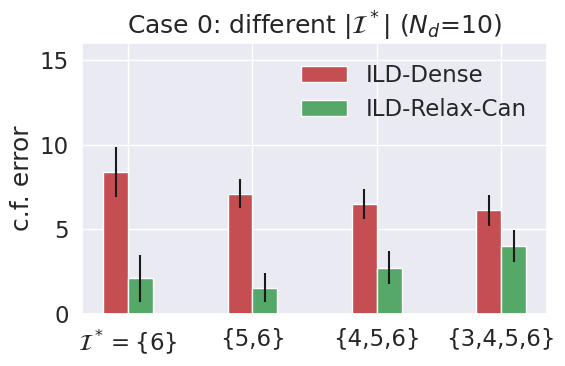

In [37]:
ks = [1,2,3,4]
intsets = ['5','4,5','3,4,5','2,3,4,5']


# ks = [1,3,4]
# intsets = ['5','3,4,5','2,3,4,5']

#candidates = ['auto_full','auto_true_spa','auto_spa_can']
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 6
ndomain = 10


for k,intset in zip(ks,intsets):
    print(f'Intset = {intset}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k

    df = find_best(stats_all,specs,candidates)
    display(df)

means = np.zeros((len(intsets),len(candidates)))
stes = np.zeros((len(intsets),len(candidates)))

for idx,(k,intset) in enumerate(zip(ks,intsets)):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k
    
        df = find_best(stats_all,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste']
        #stes[idx,jdx] = df['ste(10)']


gen_bar_plot(means,stes,candidates,len(intsets),
             ticks=[f'$\mathcal{{I}}^*=${{{nt_int(intset)}}}' for intset in [intsets[0]]]+[f'{{{nt_int(intset)}}}' for intset in intsets[1:]],
             title=f'Case 0: different $ |\mathcal{{I}}^*|$ ({nt_nd}={ndomain})',
             ticks_rot=rot ,
             ylim=(0,16),
            save_dir=f'spa_ndomain{ndomain}')



## Case 2: Int set index

### Different indices

Intset = 4,5


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_true_spa,2.904,0.946,0.946,2.991,1.562,3.985,0.329,0.391,2.405,10.36,4.951,0.461,4.144,0.455
auto_full,7.243,1.224,1.224,3.872,10.196,7.455,1.968,3.971,3.736,5.91,14.208,8.175,12.678,4.138


Intset = 3,4


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_true_spa,5.868,2.034,2.034,6.432,1.395,0.862,1.338,0.193,7.557,12.422,21.762,3.879,2.352,6.922
auto_full,8.278,1.814,1.814,5.735,8.610,5.979,4.134,2.983,9.795,4.719,24.232,5.327,8.497,8.500


Intset = 2,3


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_true_spa,3.646,0.973,0.973,3.078,1.266,4.301,0.152,2.363,7.272,1.961,3.397,0.408,4.850,10.487
auto_full,7.821,1.158,1.158,3.662,5.231,9.343,5.043,1.828,5.506,7.990,11.606,11.343,14.538,5.778


Intset = 1,2


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_true_spa,2.906,0.854,0.854,2.700,1.658,5.495,0.276,0.380,1.766,9.280,2.720,1.251,1.309,4.926
auto_full,7.734,1.280,1.280,4.048,8.395,6.660,1.684,1.723,8.756,8.648,12.416,8.619,15.348,5.086


Intset = 0,1


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_true_spa,1.571,0.787,0.787,2.488,8.785,2.113,0.057,0.060,1.07,1.066,0.837,1.364,0.300,0.055
auto_full,8.348,1.175,1.175,3.716,10.713,4.784,1.801,5.181,8.08,15.038,7.335,7.833,10.199,12.516


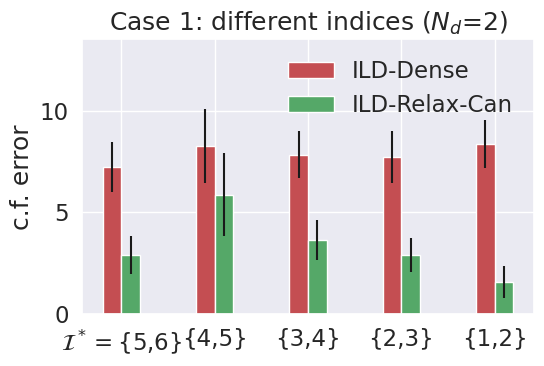

In [38]:

intsets = ['4,5','3,4','2,3','1,2','0,1']
#candidates = ['auto_full','auto_true_spa','auto_spa_can']
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 6
ndomain = 2
k_spa = 2


for intset in intsets:
    print(f'Intset = {intset}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best(stats_extra,specs,candidates)
    df = df[column_name]
    display(df)

means = np.zeros((len(intsets),len(candidates)))
stes = np.zeros((len(intsets),len(candidates)))

for idx,intset in enumerate(intsets):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa
    
        df = find_best(stats_extra,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste']
        #stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot(means,stes,candidates,len(intsets),
             ticks=[f'$\mathcal{{I}}^*=${{{nt_int(intset)}}}' for intset in [intsets[0]]]+[f'{{{nt_int(intset)}}}' for intset in intsets[1:]],
             #title=f'$\mathcal{{I}}$ ({nt_dim}={latent_dim}, {nt_nd}={ndomain})',
             title=f'Case 1: different indices ({nt_nd}={ndomain})',
             ticks_rot=rot ,
             ylim = (0,13.5),
            save_dir=f'intpos_ndomain{ndomain}')

# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(5)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ['I={}'.format(intset) for intset in intsets])
# plt.show()

Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,2.635,0.968,0.968,3.062,0.594,0.692,2.079,7.209,0.188,2.235,0.370,0.159,3.361,9.466
auto_full,8.725,1.359,1.359,4.299,11.467,12.357,5.558,18.821,9.238,4.246,6.106,3.924,7.573,7.962


Intset = 3,4


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,3.679,1.215,1.215,3.842,7.150,2.706,1.509,13.352,0.866,1.230,0.98,0.796,2.303,5.902
auto_full,8.713,1.624,1.624,5.135,12.892,12.554,5.940,21.474,6.894,4.997,4.72,4.302,6.373,6.986


Intset = 2,3


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,3.044,0.973,0.973,3.075,6.573,0.648,0.431,10.405,3.276,4.235,1.763,0.779,0.999,1.329
auto_full,8.088,1.208,1.208,3.819,9.454,16.089,7.797,14.111,5.859,6.078,4.027,4.472,6.527,6.468


Intset = 1,2


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,4.271,2.201,2.201,6.962,2.856,0.360,1.430,24.608,1.704,1.243,0.703,0.224,4.411,5.173
auto_full,8.118,1.939,1.939,6.132,9.109,6.339,9.295,25.632,7.132,6.219,3.490,3.604,5.029,5.331


Intset = 0,1


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,1.631,0.525,0.525,1.659,0.697,0.210,0.686,5.309,4.123,0.469,1.088,0.120,1.722,1.888
auto_full,7.655,1.658,1.658,5.244,20.117,2.597,7.700,14.270,7.729,5.613,4.435,2.175,5.754,6.163


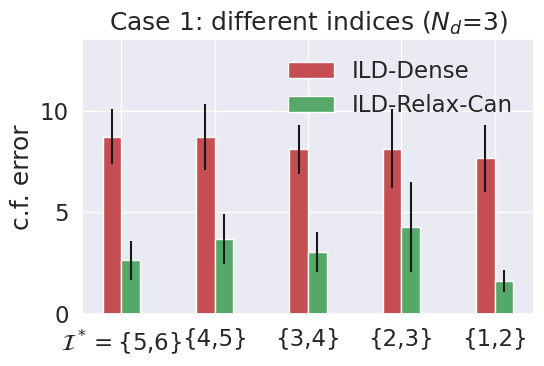

In [39]:

intsets = ['4,5','3,4','2,3','1,2','0,1']
#candidates = ['auto_full','auto_true_spa','auto_spa_can']
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 6
ndomain = 3
k_spa = 2


for intset in intsets:
    print(f'Intset = {intset}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best(stats,specs,candidates)
    display(df)

means = np.zeros((len(intsets),len(candidates)))
stes = np.zeros((len(intsets),len(candidates)))

for idx,intset in enumerate(intsets):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa
    
        df = find_best(stats,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste']
        #stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot(means,stes,candidates,len(intsets),
             ticks=[f'$\mathcal{{I}}^*=${{{nt_int(intset)}}}' for intset in [intsets[0]]]+[f'{{{nt_int(intset)}}}' for intset in intsets[1:]],
             #title=f'$\mathcal{{I}}$ ({nt_dim}={latent_dim}, {nt_nd}={ndomain})',
             title=f'Case 1: different indices ({nt_nd}={ndomain})',
             ticks_rot=rot ,
             ylim = (0,13.5),
            save_dir=f'intpos_ndomain{ndomain}')

# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(5)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ['I={}'.format(intset) for intset in intsets])
# plt.show()

Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,1.566,0.866,0.866,2.740,0.539,0.746,0.266,9.162,0.315,0.328,3.795,0.171,0.140,0.193
auto_full,7.116,0.865,0.865,2.735,9.234,11.070,4.535,12.342,7.540,3.636,5.546,5.254,6.075,5.926


Intset = 3,4


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,1.681,0.455,0.455,1.439,3.962,1.649,1.116,4.389,2.854,0.952,0.342,0.471,0.369,0.704
auto_full,6.853,1.161,1.161,3.673,11.277,11.933,3.578,13.651,5.790,4.149,3.644,3.795,5.316,5.396


Intset = 2,3


,mean,ste,ste(10),std,8,7,6,9,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,2.489,0.746,0.746,2.359,2.081,1.011,7.747,6.024,2.756,2.429,0.739,0.356,0.516,1.229
auto_full,7.218,1.412,1.412,4.465,13.895,5.020,16.825,10.054,4.966,4.827,3.372,3.955,4.559,4.710


Intset = 1,2


,mean,ste,ste(10),std,7,6,3,2,9,8,5,4,1,0
model,,,,,,,,,,,,,,
auto_true_spa,3.921,1.136,1.136,3.592,3.244,13.405,0.929,0.998,4.905,2.457,2.415,3.919,6.238,0.697
auto_full,7.497,1.593,1.593,5.037,6.013,21.206,3.072,3.610,8.846,9.968,6.700,4.194,6.873,4.486


Intset = 0,1


,mean,ste,ste(10),std,9,8,7,0,6,5,4,3,2,1
model,,,,,,,,,,,,,,
auto_true_spa,1.253,0.566,0.566,1.789,0.811,0.572,0.897,0.267,6.555,0.243,0.865,0.853,0.367,1.100
auto_full,6.614,1.203,1.203,3.804,13.397,7.176,5.608,4.633,14.183,5.047,4.753,3.219,2.372,5.757


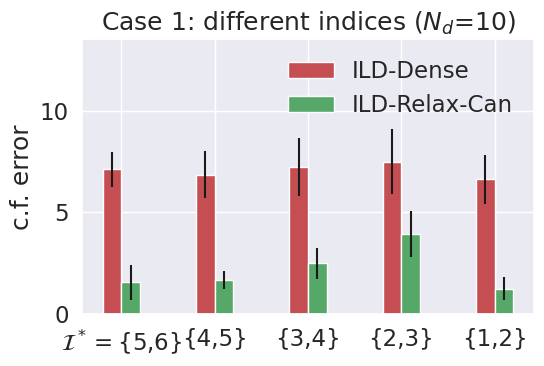

In [40]:

intsets = ['4,5','3,4','2,3','1,2','0,1']
#candidates = ['auto_full','auto_true_spa','auto_spa_can']
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 6
ndomain = 10
k_spa = 2


for intset in intsets:
    print(f'Intset = {intset}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best(stats_extra,specs,candidates)
    display(df)

means = np.zeros((len(intsets),len(candidates)))
stes = np.zeros((len(intsets),len(candidates)))

for idx,intset in enumerate(intsets):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa
    
        df = find_best(stats_extra,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste']
        #stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot(means,stes,candidates,len(intsets),
             ticks=[f'$\mathcal{{I}}^*=${{{nt_int(intset)}}}' for intset in [intsets[0]]]+[f'{{{nt_int(intset)}}}' for intset in intsets[1:]],
             #title=f'$\mathcal{{I}}$ ({nt_dim}={latent_dim}, {nt_nd}={ndomain})',
             title=f'Case 1: different indices ({nt_nd}={ndomain})',
             ticks_rot=rot ,
             ylim = (0,13.5),
            save_dir=f'intpos_ndomain{ndomain}')

# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(5)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ['I={}'.format(intset) for intset in intsets])
# plt.show()

### Different Number of domains

number of domains = 2


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,1.571,0.787,0.787,2.488,0.055,0.300,1.364,0.837,1.068,1.07,0.059,0.057,2.111,8.785
auto_full,8.237,1.189,1.189,3.760,12.517,10.199,7.833,6.231,15.033,8.08,5.181,1.802,4.784,10.713


number of domains = 3


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,1.631,0.525,0.525,1.659,0.697,0.210,0.686,5.309,4.123,0.469,1.088,0.120,1.722,1.888
auto_full,7.655,1.658,1.658,5.244,20.117,2.597,7.700,14.270,7.729,5.613,4.435,2.175,5.754,6.163


number of domains = 5


,mean,ste,ste(10),std,9,8,5,7,4,6,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,0.996,0.327,0.327,1.034,1.025,0.357,0.422,0.705,0.086,3.635,0.742,0.347,2.151,0.492
auto_full,6.064,1.175,1.175,3.717,15.060,7.670,4.219,4.236,4.741,9.796,2.364,1.918,5.635,5.001


number of domains = 10


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,1.280,0.590,0.590,1.865,0.810,0.587,0.897,6.812,0.246,0.865,0.853,0.367,1.100,0.267
auto_full,6.609,1.204,1.204,3.808,13.407,7.150,5.606,14.183,5.031,4.752,3.213,2.359,5.757,4.633


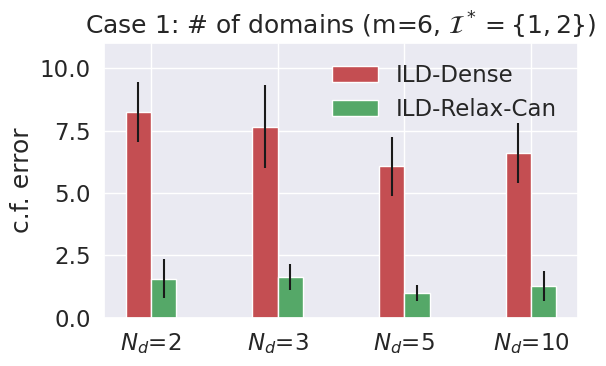

In [41]:
nds = [2,3,5,10]
#nds = [2,3,5]
#candidates = ['auto_full','auto_true_spa','auto_spa_can']
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 6
int_set = '0,1'
k_spa = 2


for nd in nds:
    print(f'number of domains = {nd}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = nd
    specs['int_set'] = int_set
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best(stats,specs,candidates)
    display(df)

means = np.zeros((len(nds),len(candidates)))
stes = np.zeros((len(nds),len(candidates)))

for idx,nd in enumerate(nds):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = nd
        specs['int_set'] = int_set
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa

        df = find_best(stats,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste(10)']
        
        
gen_bar_plot(means,stes,candidates,len(nds),
            ticks= (f'{nt_nd}=2', f'{nt_nd}=3',f'{nt_nd}=5', f'{nt_nd}=10'),
#             ticks= (f'{nt_nd}=2',f'{nt_nd}=3',f'{nt_nd}=5'),
             title='Case 1: # of domains (m=6, $\mathcal{{I}}^* = \{1,2\}$)',
             ticks_rot=rot ,
             ylim=(0,11),
            save_dir='intpos01_ndomain_dim6')


# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(5)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, (f'{nt_nd}=2', f'{nt_nd}=3',f'{nt_nd}=5', f'{nt_nd}=8',f'{nt_nd}=10'))
# plt.show()

number of domains = 2


,mean,ste,ste(10),std,2,3,9,8,7,6,4,5,0,1
model,,,,,,,,,,,,,,
auto_true_spa,0.958,0.496,0.496,1.569,0.137,0.657,0.169,0.340,1.201,5.582,0.331,0.350,0.546,0.266
auto_full,3.952,0.477,0.477,1.510,4.545,1.554,5.196,4.895,6.282,4.326,3.145,5.031,3.062,1.486


number of domains = 3


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,0.695,0.134,0.134,0.423,0.42,0.338,0.754,0.620,0.744,0.637,1.636,0.259,1.262,0.279
auto_full,5.811,1.485,1.485,4.696,2.69,19.477,4.628,5.194,3.485,6.623,3.290,3.294,3.966,5.462


number of domains = 5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,0.888,0.346,0.346,1.095,0.802,1.009,0.689,4.092,0.558,0.301,0.566,0.398,0.214,0.254
auto_full,5.132,1.253,1.253,3.961,3.009,16.078,3.930,4.461,3.626,7.827,3.006,2.463,2.059,4.859


number of domains = 10


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,0.787,0.129,0.129,0.409,0.792,1.193,1.080,1.017,0.630,0.202,1.432,0.979,0.171,0.379
auto_full,4.926,1.503,1.503,4.752,3.023,18.737,4.233,4.343,2.039,6.070,2.916,2.245,2.141,3.515


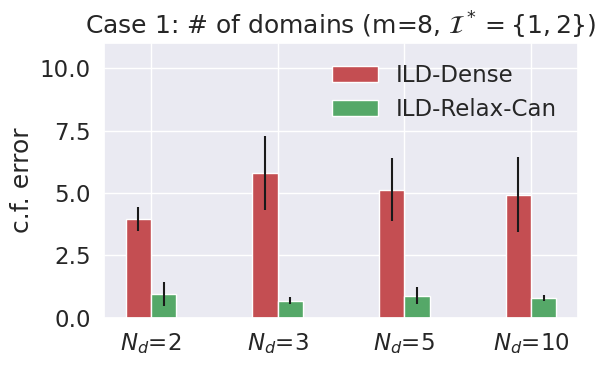

In [42]:
nds = [2,3,5,10]
#nds = [2,3,5]
#candidates = ['auto_full','auto_true_spa','auto_spa_can']
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 8
int_set = '0,1'
k_spa = 2


for nd in nds:
    print(f'number of domains = {nd}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = nd
    specs['int_set'] = int_set
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best(stats_all,specs,candidates)
    display(df)

means = np.zeros((len(nds),len(candidates)))
stes = np.zeros((len(nds),len(candidates)))

for idx,nd in enumerate(nds):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = nd
        specs['int_set'] = int_set
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa

        df = find_best(stats_all,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste(10)']
        
        
gen_bar_plot(means,stes,candidates,len(nds),
            ticks= (f'{nt_nd}=2', f'{nt_nd}=3',f'{nt_nd}=5', f'{nt_nd}=10'),
#             ticks= (f'{nt_nd}=2',f'{nt_nd}=3',f'{nt_nd}=5'),
             title='Case 1: # of domains (m=8, $\mathcal{{I}}^* = \{1,2\}$)',
             ticks_rot=rot ,
             ylim=(0,11),
            save_dir='intpos01_ndomain_dim8')


# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(5)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, (f'{nt_nd}=2', f'{nt_nd}=3',f'{nt_nd}=5', f'{nt_nd}=8',f'{nt_nd}=10'))
# plt.show()

number of domains = 2


,mean,ste,ste(10),std,9,8,3,2,1,0,7,6,5,4
model,,,,,,,,,,,,,,
auto_true_spa,1.034,0.457,0.457,1.445,0.051,0.010,0.566,0.203,2.278,4.909,1.001,0.301,0.898,0.123
auto_full,3.876,0.619,0.619,1.957,2.220,3.839,5.791,1.654,5.207,2.809,6.287,6.942,2.970,1.045


number of domains = 3


,mean,ste,ste(10),std,1,0,9,8,7,6,5,4,3,2
model,,,,,,,,,,,,,,
auto_true_spa,0.716,0.177,0.177,0.558,2.048,1.153,1.037,0.173,0.761,0.32,0.688,0.126,0.626,0.228
auto_full,4.425,0.829,0.829,2.622,2.511,8.817,8.894,0.851,5.486,5.47,2.457,3.599,4.242,1.923


number of domains = 5


,mean,ste,ste(10),std,7,4,2,9,8,6,5,3,1,0
model,,,,,,,,,,,,,,
auto_true_spa,0.716,0.178,0.178,0.564,0.443,0.30,0.210,2.078,0.345,0.297,1.043,0.440,0.717,1.288
auto_full,5.305,0.538,0.538,1.701,5.482,5.01,2.954,8.076,6.483,4.292,4.376,3.311,4.905,8.166


number of domains = 10


,mean,ste,ste(10),std,5,4,0,9,8,7,6,3,2,1
model,,,,,,,,,,,,,,
auto_true_spa,0.790,0.155,0.155,0.491,0.486,0.635,1.430,1.926,0.440,0.669,0.402,0.713,0.260,0.935
auto_full,4.598,0.423,0.423,1.338,3.570,4.566,6.973,6.005,6.241,5.012,3.914,3.513,2.818,3.363


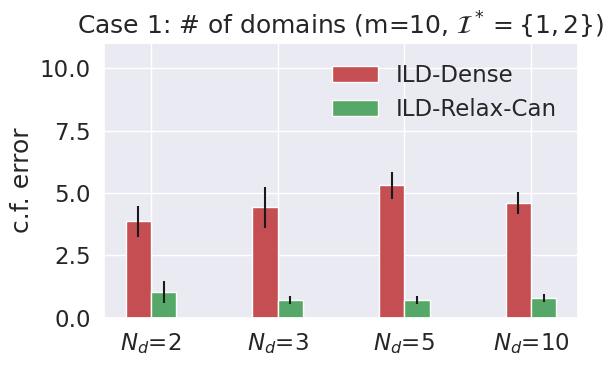

In [43]:
nds = [2,3,5,10]
#nds = [2,3,5]
#candidates = ['auto_full','auto_true_spa','auto_spa_can']
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 10
int_set = '0,1'
k_spa = 2


for nd in nds:
    print(f'number of domains = {nd}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = nd
    specs['int_set'] = int_set
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best(stats_extra,specs,candidates)
    display(df)

means = np.zeros((len(nds),len(candidates)))
stes = np.zeros((len(nds),len(candidates)))

for idx,nd in enumerate(nds):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = nd
        specs['int_set'] = int_set
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa

        df = find_best(stats_extra,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste(10)']
        
        
gen_bar_plot(means,stes,candidates,len(nds),
            ticks= (f'{nt_nd}=2', f'{nt_nd}=3',f'{nt_nd}=5', f'{nt_nd}=10'),
#             ticks= (f'{nt_nd}=2',f'{nt_nd}=3',f'{nt_nd}=5'),
             title='Case 1: # of domains (m=10, $\mathcal{{I}}^* = \{1,2\}$)',
             ticks_rot=rot ,
             ylim=(0,11),
            save_dir='intpos01_ndomain_dim10')


# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(5)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, (f'{nt_nd}=2', f'{nt_nd}=3',f'{nt_nd}=5', f'{nt_nd}=8',f'{nt_nd}=10'))
# plt.show()

## Int set size

### Change set size

Intset = 5


,mean,ste,ste(10),std,9,8,6,7,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,2.729,0.921,0.921,2.911,0.259,7.249,3.835,0.873,8.936,2.687,0.160,0.844,1.639,0.810
auto_full,11.330,2.814,2.814,8.900,10.181,31.877,24.079,5.676,7.691,6.320,5.685,1.400,9.035,11.357


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,2.920,0.949,0.949,3.002,0.454,4.141,0.461,5.115,10.360,2.405,0.391,0.329,3.983,1.562
auto_full,7.246,1.228,1.228,3.885,4.137,12.677,8.121,14.286,5.909,3.737,3.971,1.968,7.455,10.196


Intset = 3,4,5


,mean,ste,ste(10),std,9,8,6,7,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,5.894,1.775,1.775,5.614,5.194,7.166,19.169,1.462,13.335,3.075,0.902,3.133,3.643,1.862
auto_full,8.640,1.585,1.585,5.013,9.889,15.842,19.355,8.308,6.871,5.075,4.398,3.102,4.376,9.180


Intset = 2,3,4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,5.364,1.381,1.381,4.368,3.355,6.559,1.324,15.936,5.905,5.570,2.055,0.714,2.703,9.521
auto_full,8.776,2.421,2.421,7.656,10.830,27.929,8.322,17.032,3.505,4.235,3.828,2.344,3.893,5.846


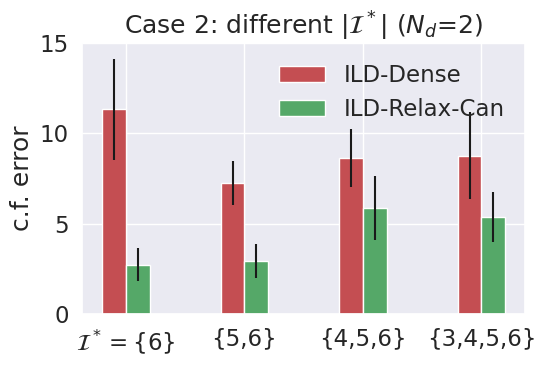

In [44]:

intsets = ['5','4,5','3,4,5','2,3,4,5','1,2,3,4,5']
intsets = ['5','4,5','3,4,5','2,3,4,5']
#candidates = ['auto_full','auto_true_spa','auto_spa_can']
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 6
ndomain = 2
k_spa = 2


for intset in intsets:
    print(f'Intset = {intset}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best(stats_all,specs,candidates)
    display(df)

means = np.zeros((len(intsets),len(candidates)))
stes = np.zeros((len(intsets),len(candidates)))

for idx,intset in enumerate(intsets):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa
    
        df = find_best(stats_all,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste']
        #stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot(means,stes,candidates,len(intsets),
             ticks=[f'$\mathcal{{I}}^*=${{{nt_int(intset)}}}' for intset in [intsets[0]]]+[f'{{{nt_int(intset)}}}' for intset in intsets[1:]],
             title=f'Case 2: different $|\mathcal{{I}}^*|$ ({nt_nd}={ndomain})',
             ticks_rot=rot ,
             ylim=(0,15),
            save_dir=f'intsize_ndomain{ndomain}')


# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(5)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ['I={}'.format(intset) for intset in intsets])
# plt.show()

Intset = 5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,1.698,0.719,0.719,2.275,6.867,0.431,0.623,5.239,0.121,0.275,2.066,0.186,0.999,0.177
auto_full,10.409,2.211,2.211,6.991,11.779,14.634,4.763,29.284,9.440,5.037,4.774,7.368,7.309,9.702


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,2.635,0.968,0.968,3.062,0.594,0.692,2.079,7.209,0.188,2.235,0.370,0.159,3.361,9.466
auto_full,8.725,1.359,1.359,4.299,11.467,12.357,5.558,18.821,9.238,4.246,6.106,3.924,7.573,7.962


Intset = 3,4,5


,mean,ste,ste(10),std,9,8,6,7,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,4.283,1.123,1.123,3.551,7.059,1.081,11.567,3.740,1.736,0.756,1.856,1.672,4.269,9.095
auto_full,7.358,1.014,1.014,3.208,7.139,8.750,15.421,5.774,8.915,4.330,4.731,3.835,6.227,8.456


Intset = 2,3,4,5


,mean,ste,ste(10),std,9,8,6,7,5,4,3,2,0,1
model,,,,,,,,,,,,,,
auto_true_spa,3.165,0.505,0.505,1.595,2.918,1.427,6.713,4.617,3.823,2.729,2.166,1.721,1.415,4.118
auto_full,6.665,0.622,0.622,1.967,6.490,9.370,10.099,6.562,5.303,4.610,3.692,5.528,6.515,8.482


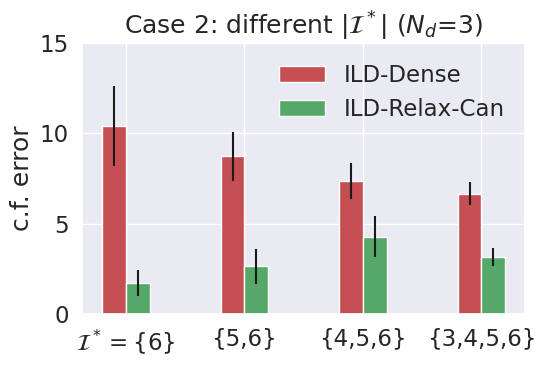

In [46]:
## intsets = ['5','4,5','3,4,5','2,3,4,5','1,2,3,4,5']
intsets = ['5','4,5','3,4,5','2,3,4,5']
#candidates = ['auto_full','auto_true_spa','auto_spa_can']
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 6
ndomain = 3
k_spa = 2


for intset in intsets:
    print(f'Intset = {intset}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best(stats,specs,candidates)
    display(df)

means = np.zeros((len(intsets),len(candidates)))
stes = np.zeros((len(intsets),len(candidates)))

for idx,intset in enumerate(intsets):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa
    
        df = find_best(stats,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste']
        #stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot(means,stes,candidates,len(intsets),
             ticks=[f'$\mathcal{{I}}^*=${{{nt_int(intset)}}}' for intset in [intsets[0]]]+[f'{{{nt_int(intset)}}}' for intset in intsets[1:]],
             title=f'Case 2: different $|\mathcal{{I}}^*|$ ({nt_nd}={ndomain})',
             ticks_rot=rot ,
             ylim=(0,15),
            save_dir=f'intsize_ndomain{ndomain}')


# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(5)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ['I={}'.format(intset) for intset in intsets])
# plt.show()

Intset = 5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,0,1
model,,,,,,,,,,,,,,
auto_true_spa,1.553,0.693,0.693,2.191,2.771,0.281,0.313,7.741,0.244,1.469,1.132,0.643,0.505,0.429
auto_full,8.389,1.500,1.500,4.743,8.173,14.294,5.335,20.014,8.152,4.363,4.948,5.102,7.567,5.942


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,1.566,0.866,0.866,2.740,0.539,0.746,0.266,9.162,0.315,0.328,3.795,0.171,0.140,0.193
auto_full,7.115,0.865,0.865,2.734,9.234,11.064,4.535,12.342,7.540,3.636,5.546,5.253,6.074,5.926


Intset = 3,4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,2.565,0.688,0.688,2.177,4.601,1.155,2.289,8.401,1.602,1.030,1.721,1.519,2.129,1.204
auto_full,6.509,0.879,0.879,2.778,7.957,11.703,4.233,11.444,6.099,3.681,4.826,4.167,5.608,5.375


Intset = 2,3,4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,3.334,0.395,0.395,1.249,4.743,3.09,3.594,5.943,3.771,1.904,3.615,1.578,2.706,2.393
auto_full,6.104,0.881,0.881,2.787,7.318,9.44,4.088,12.801,4.727,3.741,4.413,4.227,5.613,4.674


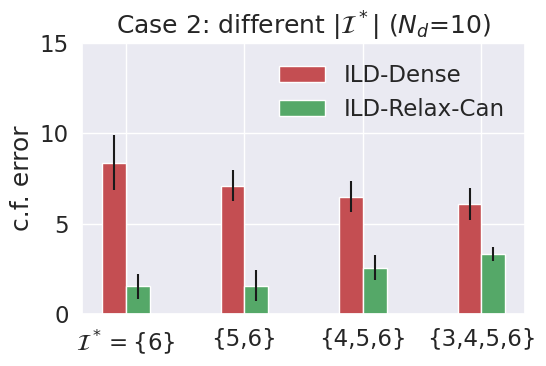

In [47]:

intsets = ['5','4,5','3,4,5','2,3,4,5','1,2,3,4,5']
intsets = ['5','4,5','3,4,5','2,3,4,5']
#candidates = ['auto_full','auto_true_spa','auto_spa_can']
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 6
ndomain = 10
k_spa = 2


for intset in intsets:
    print(f'Intset = {intset}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best(stats_all,specs,candidates)
    display(df)

means = np.zeros((len(intsets),len(candidates)))
stes = np.zeros((len(intsets),len(candidates)))

for idx,intset in enumerate(intsets):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa
    
        df = find_best(stats_all,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste']
        #stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot(means,stes,candidates,len(intsets),
             ticks=[f'$\mathcal{{I}}^*=${{{nt_int(intset)}}}' for intset in [intsets[0]]]+[f'{{{nt_int(intset)}}}' for intset in intsets[1:]],
             title=f'Case 2: different $|\mathcal{{I}}^*|$ ({nt_nd}={ndomain})',
             ticks_rot=rot ,
             ylim=(0,15),
            save_dir=f'intsize_ndomain{ndomain}')


# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(5)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ['I={}'.format(intset) for intset in intsets])
# plt.show()

### Change k

Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,2.722,0.860,0.860,2.719,1.059,1.833,1.355,4.233,4.456,1.093,1.904,9.905,0.889,0.495
auto_full,7.243,1.228,1.228,3.882,4.137,12.656,8.121,14.286,5.909,3.737,3.971,1.968,7.455,10.196


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,2.920,0.949,0.949,3.002,0.454,4.141,0.461,5.115,10.360,2.405,0.391,0.329,3.983,1.562
auto_full,7.246,1.228,1.228,3.885,4.137,12.677,8.121,14.286,5.909,3.737,3.971,1.968,7.455,10.196


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,2.246,1.068,1.068,3.376,0.863,1.845,1.949,12.142,2.397,1.424,0.168,0.597,0.930,0.141
auto_full,7.243,1.228,1.228,3.882,4.137,12.656,8.121,14.286,5.909,3.737,3.971,1.968,7.455,10.196


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,6.299,1.865,1.865,5.898,4.018,15.912,3.646,18.860,2.410,2.388,8.585,2.583,3.676,0.910
auto_full,7.243,1.228,1.228,3.882,4.137,12.656,8.121,14.286,5.909,3.737,3.971,1.968,7.455,10.196


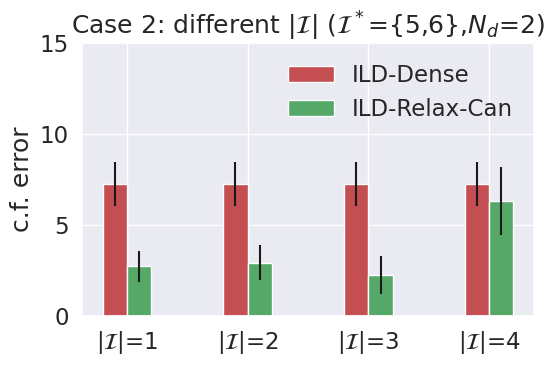

In [48]:

intset = '4,5'
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 6
ndomain = 2
k_spas = [1,2,3,4]


for k_spa in k_spas:
    print(f'Intset = {intset}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best(stats_all,specs,candidates)
    display(df)

means = np.zeros((len(k_spas),len(candidates)))
stes = np.zeros((len(k_spas),len(candidates)))

for idx,k_spa in enumerate(k_spas):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa
    
        df = find_best(stats_all,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste']
        #stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot(means,stes,candidates,len(k_spas),
             ticks=[f'$|\mathcal{{I}}|$={k_spa}' for k_spa in k_spas],
             title=f'Case 2: different $|\mathcal{{I}}|$ ($\mathcal{{I}}^*$={{5,6}},{nt_nd}={ndomain})',
             ticks_rot=rot ,
             ylim=(0,15),
            save_dir=f'intsizek_ndomain{ndomain}')


# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(5)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ['I={}'.format(intset) for intset in intsets])
# plt.show()


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,3,4,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,1.716,0.65,0.65,2.056,1.888,0.411,4.639,6.645,0.538,0.817,0.745,0.294,0.648,0.530
auto_full,8.711,1.35,1.35,4.270,11.487,12.316,5.558,18.709,9.231,6.106,4.246,3.926,7.574,7.955


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,2.635,0.968,0.968,3.062,0.594,0.692,2.079,7.209,0.188,2.235,0.370,0.159,3.361,9.466
auto_full,8.725,1.359,1.359,4.299,11.467,12.357,5.558,18.821,9.238,4.246,6.106,3.924,7.573,7.962


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,4.326,1.400,1.400,4.427,5.484,14.148,5.928,9.808,4.166,0.403,0.703,1.706,0.812,0.102
auto_full,8.733,1.368,1.368,4.325,11.467,12.357,5.545,18.927,9.231,4.245,6.106,3.924,7.574,7.955


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,3.539,0.926,0.926,2.928,5.864,1.866,2.326,11.194,1.365,2.165,4.634,2.010,3.091,0.871
auto_full,8.712,1.351,1.351,4.273,11.467,12.357,5.558,18.709,9.231,4.245,6.090,3.926,7.573,7.962


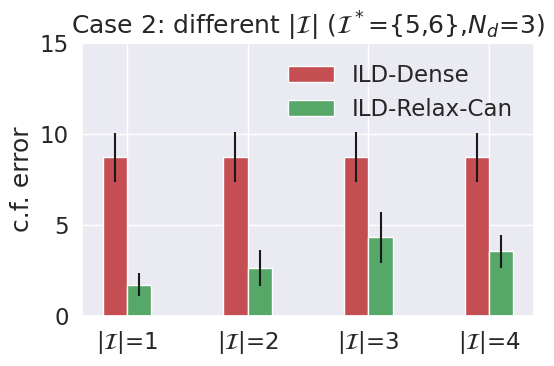

In [49]:

intset = '4,5'
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 6
ndomain = 3
k_spas = [1,2,3,4]


for k_spa in k_spas:
    print(f'Intset = {intset}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best(stats,specs,candidates)
    display(df)

means = np.zeros((len(k_spas),len(candidates)))
stes = np.zeros((len(k_spas),len(candidates)))

for idx,k_spa in enumerate(k_spas):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa
    
        df = find_best(stats,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste']
        #stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot(means,stes,candidates,len(k_spas),
             ticks=[f'$|\mathcal{{I}}|$={k_spa}' for k_spa in k_spas],
             title=f'Case 2: different $|\mathcal{{I}}|$ ($\mathcal{{I}}^*$={{5,6}},{nt_nd}={ndomain})',
             ticks_rot=rot ,
             ylim=(0,15),
            save_dir=f'intsizek_ndomain{ndomain}')


# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(5)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ['I={}'.format(intset) for intset in intsets])
# plt.show()


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,1.801,0.366,0.366,1.156,4.213,2.194,1.415,3.509,0.279,1.081,1.955,1.138,0.915,1.309
auto_full,7.127,0.871,0.871,2.753,9.260,11.070,4.535,12.425,7.540,3.636,5.546,5.254,6.075,5.926


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,1.566,0.866,0.866,2.740,0.539,0.746,0.266,9.162,0.315,0.328,3.795,0.171,0.140,0.193
auto_full,7.115,0.865,0.865,2.734,9.234,11.064,4.535,12.342,7.540,3.636,5.546,5.253,6.074,5.926


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,2.343,0.705,0.705,2.228,0.872,5.388,1.874,7.360,0.766,1.623,3.474,0.385,1.161,0.526
auto_full,7.127,0.871,0.871,2.753,9.260,11.070,4.535,12.425,7.540,3.636,5.546,5.254,6.075,5.926


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,4.686,1.171,1.171,3.703,3.207,5.264,2.705,14.637,3.478,1.433,2.870,6.354,1.167,5.744
auto_full,7.127,0.871,0.871,2.753,9.260,11.070,4.535,12.425,7.540,3.636,5.546,5.254,6.075,5.926


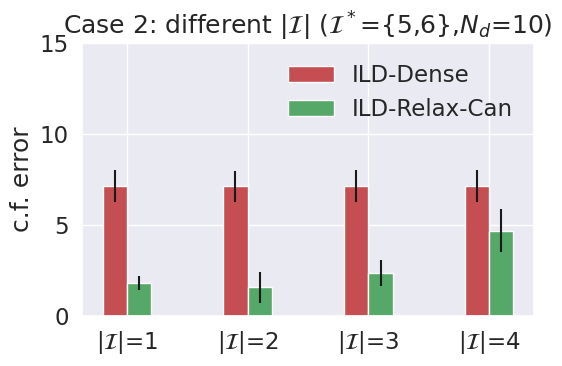

In [50]:

intset = '4,5'
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 6
ndomain = 10
k_spas = [1,2,3,4]


for k_spa in k_spas:
    print(f'Intset = {intset}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best(stats_all,specs,candidates)
    display(df)

means = np.zeros((len(k_spas),len(candidates)))
stes = np.zeros((len(k_spas),len(candidates)))

for idx,k_spa in enumerate(k_spas):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa
    
        df = find_best(stats_all,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste']
        #stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot(means,stes,candidates,len(k_spas),
             ticks=[f'$|\mathcal{{I}}|$={k_spa}' for k_spa in k_spas],
             title=f'Case 2: different $|\mathcal{{I}}|$ ($\mathcal{{I}}^*$={{5,6}},{nt_nd}={ndomain})',
             ticks_rot=rot ,
             ylim=(0,15),
            save_dir=f'intsizek_ndomain{ndomain}')


# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(5)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ['I={}'.format(intset) for intset in intsets])
# plt.show()


# Appendix - Likelihood

In [51]:
def find_rows(df, specs):
    for spec_name, spec in specs.items():
        df = df.loc[df[spec_name]==spec]
    return df

def best_test_val_likelihood(df):
    seeds = []
    error = []
    for _, row in df.iterrows():
        val_align = row['val_align']
        assert len(val_align) == 500, 'not finished'
        test_cf = row['test_cf']
        
        idx = np.argmin(val_align)
        #idx = np.argmin(test_cf) 
        
        #best_error = test_cf[idx]
        best_error = -val_align[idx]
        seed = row['seed']
        error.append(best_error)
        seeds.append(seed)
    error = error
    res = pd.DataFrame([error],columns=seeds)  
    
    res.insert(0,'std',np.std(error))
    res.insert(0,f'ste({len(seeds)})',np.std(error)/np.sqrt(len(seeds)))
    res.insert(0,'ste',np.std(error)/np.sqrt(len(seeds)))
    res.insert(0,'mean',np.mean(error))
    #res['std'] = np.std(error)
    return res

def find_best_likelihood(df, specs, candidates):
    #assert len(val_err[run_name]) == 5
    #assert len(test_err[run_name]) == 5
    df = find_rows(df, specs)
    
    all_res = []
    
    for candidate in candidates:
        df_temp = df[df['f_type'] == candidate]
        res = best_test_val_likelihood(df_temp)
        res.insert(0, 'model', candidate)
        all_res.append(res)
        #display(res)
    all_res = pd.concat(all_res)
    all_res = all_res.sort_values('mean')
    all_res.set_index('model', inplace=True)
    all_res = all_res.round(3)
    return all_res


In [52]:
global_save_dir = '/local/scratch/a/zhou1059/latentcausal/simulated/ICLR/results_app/'
def gen_bar_plot_likelihood(means,stes,candidates,nums,title=None,ticks=None,save_dir=None,ticks_rot=None,ylim=None, legend=True):
    #colors = ['y','k']
    colors = ['r','g','b','y','k']
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    X = np.arange(nums)
    for i,_ in enumerate(candidates):
        ax.bar(X+0.2*i,means[:,i],yerr=stes[:,i],color=colors[i],align='center',label=names[candidates[i]],width=0.2,alpha=0.7)
    if ticks:
        if not ticks_rot:
            ax.set_xticks(X+0.1, ticks)
        else:
            ax.set_xticks(X+0.1, ticks,rotation=ticks_rot)
    ax.set_ylabel('log likelihood')
    if legend:
        plt.legend(frameon=False)
    #legend.get_frame().set_alpha(None)
    if title:
        plt.title(title)
    if ylim:
        plt.ylim(ylim)

#    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9)
    plt.tight_layout()
    if save_dir:
        plt.savefig(global_save_dir+save_dir,dpi=300)

    plt.show()


dim = 4


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_true_spa,-3.936,0.086,0.086,0.272,-3.724,-3.777,-3.872,-4.020,-4.377,-4.016,-3.851,-3.683,-4.452,-3.590
auto_full,-3.915,0.090,0.090,0.286,-3.698,-3.767,-3.851,-4.022,-4.354,-4.005,-3.841,-3.677,-4.450,-3.486


dim = 6


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_full,-5.034,0.325,0.325,1.027,-4.156,-5.697,-3.290,-4.890,-6.017,-3.799,-5.410,-4.898,-6.924,-5.262
auto_true_spa,-5.022,0.264,0.264,0.834,-4.160,-5.671,-3.392,-4.856,-6.144,-4.176,-5.987,-5.213,-5.325,-5.292


dim = 8


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_true_spa,-4.686,0.583,0.583,1.844,-1.795,-5.097,-3.756,-6.840,-6.685,-3.714,-4.206,-7.936,-2.704,-4.127
auto_full,-4.201,0.655,0.655,2.072,-0.981,-5.020,-4.291,-6.836,-6.622,-3.712,-2.105,-6.794,-1.421,-4.227


dim = 10


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_true_spa,-4.523,0.658,0.658,2.080,-6.873,-7.066,-5.672,-4.637,-0.572,-3.261,-6.062,-4.552,-1.367,-5.170
auto_full,-3.441,0.646,0.646,2.043,-4.034,-6.434,-5.679,-4.197,0.711,-1.908,-4.180,-2.413,-1.483,-4.796


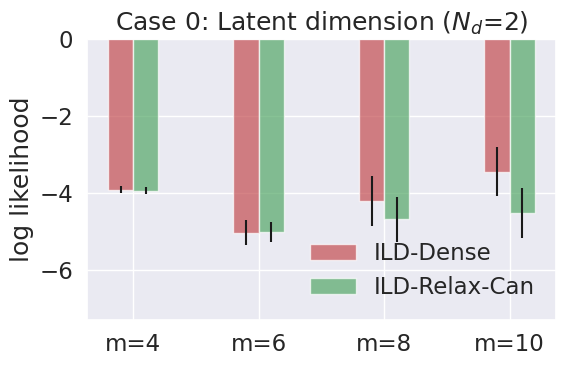

In [56]:
ndims = [4,6,8,10]
intsets = ['2,3','4,5','6,7','8,9']
#candidates = ['auto_full','auto_true_spa','auto_spa_can']
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
ndomain = 2
k_spa = 2


for nd,intset in zip(ndims,intsets):
    print(f'dim = {nd}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = nd
    specs['k_spa'] = k_spa

    df = find_best_likelihood(stats_all,specs,candidates)
    df = df[column_name]
    display(df)

means = np.zeros((len(ndims),len(candidates)))
stes = np.zeros((len(ndims),len(candidates)))

for idx,(nd,intset) in enumerate(zip(ndims,intsets)):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = nd
        specs['k_spa'] = k_spa

        df = find_best_likelihood(stats_all,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot_likelihood(means,stes,candidates,len(ndims),
             ticks=(f'{nt_dim}=4', f'{nt_dim}=6', f'{nt_dim}=8', f'{nt_dim}=10'),
             title=f'Case 0: Latent dimension ({nt_nd}={ndomain})',
             ticks_rot=rot ,
                        ylim = (-7.3,0),
            save_dir=f'like_ndim_ndomain{ndomain}')

# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(4)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ('d=4', 'd=6','d=8','d=10'))
# plt.show()

Intset = 4,5


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_full,-5.036,0.324,0.324,1.025,-4.156,-5.697,-3.290,-4.890,-6.017,-3.799,-5.436,-4.898,-6.909,-5.262
auto_true_spa,-5.024,0.264,0.264,0.836,-4.160,-5.670,-3.392,-4.856,-6.144,-4.176,-6.006,-5.212,-5.328,-5.293


Intset = 3,4


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_true_spa,-4.629,0.220,0.220,0.695,-4.441,-5.737,-4.448,-5.504,-4.393,-3.376,-5.187,-5.073,-4.033,-4.102
auto_full,-4.457,0.298,0.298,0.943,-4.170,-5.632,-4.316,-5.458,-4.174,-2.181,-4.052,-5.010,-5.270,-4.302


Intset = 2,3


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_true_spa,-4.474,0.280,0.280,0.886,-4.580,-5.397,-4.429,-4.524,-3.822,-5.803,-4.934,-4.788,-4.064,-2.399
auto_full,-4.285,0.242,0.242,0.764,-4.556,-5.254,-4.406,-4.124,-3.764,-4.138,-5.043,-4.712,-4.494,-2.364


Intset = 1,2


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_true_spa,-4.444,0.415,0.415,1.311,-4.293,-4.834,-3.922,-4.381,-5.460,-6.905,-5.419,-2.166,-4.491,-2.569
auto_full,-4.158,0.331,0.331,1.047,-4.265,-4.786,-3.812,-4.288,-5.385,-4.190,-5.332,-2.159,-4.924,-2.438


Intset = 0,1


,mean,ste,ste(10),std,0,1,2,3,4,5,6,7,8,9
model,,,,,,,,,,,,,,
auto_full,-3.845,0.415,0.415,1.314,-3.783,-5.193,-2.438,-4.983,-5.267,-2.120,-5.063,-3.808,-4.294,-1.505
auto_true_spa,-3.749,0.428,0.428,1.354,-3.799,-5.297,-2.636,-4.981,-5.208,-1.677,-5.059,-4.038,-3.206,-1.587


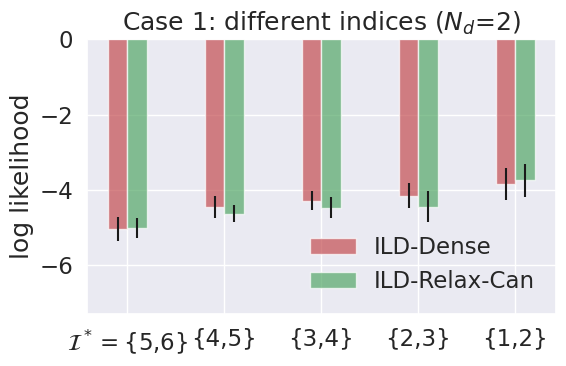

In [58]:

intsets = ['4,5','3,4','2,3','1,2','0,1']
#candidates = ['auto_full','auto_true_spa','auto_spa_can']
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 6
ndomain = 2
k_spa = 2


for intset in intsets:
    print(f'Intset = {intset}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best_likelihood(stats_extra,specs,candidates)
    df = df[column_name]
    display(df)

means = np.zeros((len(intsets),len(candidates)))
stes = np.zeros((len(intsets),len(candidates)))

for idx,intset in enumerate(intsets):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa
    
        df = find_best_likelihood(stats_extra,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste']
        #stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot_likelihood(means,stes,candidates,len(intsets),
             ticks=[f'$\mathcal{{I}}^*=${{{nt_int(intset)}}}' for intset in [intsets[0]]]+[f'{{{nt_int(intset)}}}' for intset in intsets[1:]],
             #title=f'$\mathcal{{I}}$ ({nt_dim}={latent_dim}, {nt_nd}={ndomain})',
             title=f'Case 1: different indices ({nt_nd}={ndomain})',
             ticks_rot=rot ,
             #ylim = (0,13.5),
                        ylim = (-7.3,0),
            save_dir=f'like_intpos_ndomain{ndomain}')

# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(5)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ['I={}'.format(intset) for intset in intsets])
# plt.show()

Intset = 5


,mean,ste,ste(10),std,9,8,6,7,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_full,-5.089,0.265,0.265,0.837,-5.130,-5.466,-5.462,-5.395,-3.57,-6.518,-4.826,-4.526,-5.967,-4.032
auto_true_spa,-5.089,0.240,0.240,0.760,-5.136,-4.603,-5.393,-5.590,-4.19,-6.516,-4.844,-4.550,-6.033,-4.034


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_full,-5.034,0.325,0.325,1.027,-5.262,-6.924,-4.898,-5.410,-3.799,-6.017,-4.890,-3.290,-5.697,-4.156
auto_true_spa,-5.022,0.264,0.264,0.834,-5.292,-5.325,-5.213,-5.987,-4.176,-6.144,-4.856,-3.392,-5.671,-4.160


Intset = 3,4,5


,mean,ste,ste(10),std,9,8,6,7,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,-4.971,0.174,0.174,0.551,-4.987,-4.863,-5.370,-5.333,-3.688,-5.513,-5.267,-4.744,-5.547,-4.402
auto_full,-4.634,0.273,0.273,0.862,-4.534,-5.541,-4.308,-5.247,-2.593,-5.282,-5.222,-4.185,-5.411,-4.016


Intset = 2,3,4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,-4.841,0.158,0.158,0.499,-3.891,-5.063,-5.092,-5.826,-5.096,-4.948,-4.453,-4.367,-4.995,-4.676
auto_full,-4.349,0.233,0.233,0.735,-3.310,-5.606,-4.781,-4.941,-3.261,-4.710,-3.513,-4.187,-4.758,-4.422


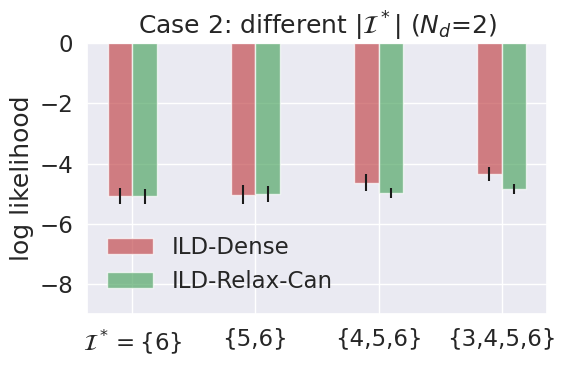

In [63]:

intsets = ['5','4,5','3,4,5','2,3,4,5','1,2,3,4,5']
intsets = ['5','4,5','3,4,5','2,3,4,5']
#candidates = ['auto_full','auto_true_spa','auto_spa_can']
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 6
ndomain = 2
k_spa = 2


for intset in intsets:
    print(f'Intset = {intset}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best_likelihood(stats_all,specs,candidates)
    display(df)

means = np.zeros((len(intsets),len(candidates)))
stes = np.zeros((len(intsets),len(candidates)))

for idx,intset in enumerate(intsets):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa
    
        df = find_best_likelihood(stats_all,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste']
        #stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot_likelihood(means,stes,candidates,len(intsets),
             ticks=[f'$\mathcal{{I}}^*=${{{nt_int(intset)}}}' for intset in [intsets[0]]]+[f'{{{nt_int(intset)}}}' for intset in intsets[1:]],
             title=f'Case 2: different $|\mathcal{{I}}^*|$ ({nt_nd}={ndomain})',
             ticks_rot=rot ,
                        ylim=(-9,0),
            save_dir=f'like_intsize_ndomain{ndomain}')


# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(5)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ['I={}'.format(intset) for intset in intsets])
# plt.show()

Intset = 5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,-5.193,0.238,0.238,0.753,-5.396,-4.817,-5.769,-5.296,-4.641,-6.790,-4.922,-4.478,-5.789,-4.034
auto_full,-4.993,0.258,0.258,0.816,-5.397,-4.502,-5.466,-5.392,-3.346,-6.195,-4.858,-4.925,-5.844,-4.008


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,-5.186,0.326,0.326,1.031,-5.757,-4.948,-5.393,-5.923,-4.126,-7.048,-5.295,-3.222,-5.845,-4.307
auto_full,-4.842,0.254,0.254,0.803,-5.734,-4.915,-4.880,-5.588,-3.844,-5.348,-5.019,-3.234,-5.701,-4.153


Intset = 3,4,5


,mean,ste,ste(10),std,9,8,6,7,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,-5.227,0.175,0.175,0.553,-5.548,-4.481,-5.357,-6.004,-4.612,-5.205,-5.650,-4.647,-6.033,-4.737
auto_full,-4.614,0.222,0.222,0.702,-4.952,-4.297,-4.582,-5.147,-2.999,-4.830,-5.452,-4.080,-5.456,-4.343


Intset = 2,3,4,5


,mean,ste,ste(10),std,9,8,6,7,5,4,3,2,0,1
model,,,,,,,,,,,,,,
auto_true_spa,-4.98,0.181,0.181,0.574,-4.608,-4.645,-5.242,-5.527,-6.100,-4.875,-4.979,-3.820,-4.824,-5.182
auto_full,-4.16,0.159,0.159,0.501,-4.132,-4.260,-4.566,-4.723,-3.831,-4.254,-4.395,-2.827,-4.181,-4.429


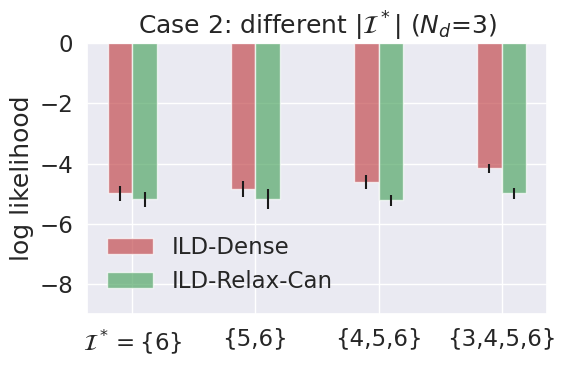

In [64]:

intsets = ['5','4,5','3,4,5','2,3,4,5','1,2,3,4,5']
intsets = ['5','4,5','3,4,5','2,3,4,5']
#candidates = ['auto_full','auto_true_spa','auto_spa_can']
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 6
ndomain = 3
k_spa = 2


for intset in intsets:
    print(f'Intset = {intset}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best_likelihood(stats_all,specs,candidates)
    display(df)

means = np.zeros((len(intsets),len(candidates)))
stes = np.zeros((len(intsets),len(candidates)))

for idx,intset in enumerate(intsets):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa
    
        df = find_best_likelihood(stats_all,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste']
        #stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot_likelihood(means,stes,candidates,len(intsets),
             ticks=[f'$\mathcal{{I}}^*=${{{nt_int(intset)}}}' for intset in [intsets[0]]]+[f'{{{nt_int(intset)}}}' for intset in intsets[1:]],
             title=f'Case 2: different $|\mathcal{{I}}^*|$ ({nt_nd}={ndomain})',
             ticks_rot=rot ,
                        ylim=(-9,0),
            save_dir=f'like_intsize_ndomain{ndomain}')


# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(5)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ['I={}'.format(intset) for intset in intsets])
# plt.show()

Intset = 5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,0,1
model,,,,,,,,,,,,,,
auto_true_spa,-5.183,0.247,0.247,0.781,-5.327,-5.059,-5.527,-5.931,-3.922,-6.344,-4.956,-5.021,-3.828,-5.916
auto_full,-5.027,0.267,0.267,0.843,-5.316,-4.660,-5.685,-5.325,-3.747,-6.339,-4.904,-4.675,-3.632,-5.986


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,-5.084,0.172,0.172,0.543,-5.577,-5.474,-4.759,-5.58,-4.500,-5.436,-5.629,-4.118,-5.338,-4.423
auto_full,-4.964,0.189,0.189,0.596,-5.545,-5.434,-5.045,-4.95,-4.434,-5.432,-5.549,-3.633,-5.212,-4.404


Intset = 3,4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,-5.363,0.145,0.145,0.457,-5.567,-5.317,-5.564,-5.021,-4.364,-5.407,-6.276,-5.182,-5.453,-5.480
auto_full,-4.644,0.168,0.168,0.530,-4.804,-4.595,-4.856,-4.327,-3.511,-4.875,-5.744,-4.363,-4.617,-4.745


Intset = 2,3,4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,-5.619,0.085,0.085,0.270,-5.277,-5.466,-5.673,-6.031,-6.053,-5.548,-5.698,-5.157,-5.675,-5.61
auto_full,-4.237,0.054,0.054,0.169,-4.268,-3.850,-4.242,-4.294,-4.198,-4.487,-4.413,-4.053,-4.274,-4.29


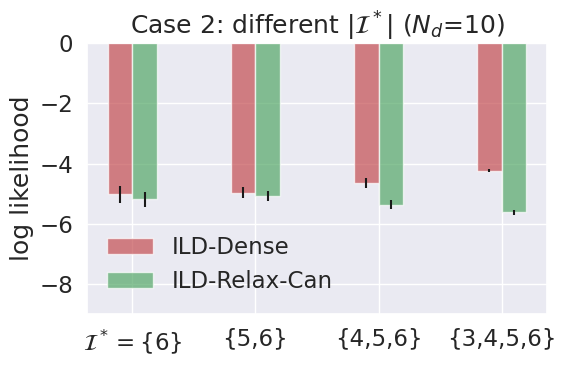

In [65]:

intsets = ['5','4,5','3,4,5','2,3,4,5','1,2,3,4,5']
intsets = ['5','4,5','3,4,5','2,3,4,5']
#candidates = ['auto_full','auto_true_spa','auto_spa_can']
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 6
ndomain = 10
k_spa = 2


for intset in intsets:
    print(f'Intset = {intset}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best_likelihood(stats_all,specs,candidates)
    display(df)

means = np.zeros((len(intsets),len(candidates)))
stes = np.zeros((len(intsets),len(candidates)))

for idx,intset in enumerate(intsets):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa
    
        df = find_best_likelihood(stats_all,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste']
        #stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot_likelihood(means,stes,candidates,len(intsets),
             ticks=[f'$\mathcal{{I}}^*=${{{nt_int(intset)}}}' for intset in [intsets[0]]]+[f'{{{nt_int(intset)}}}' for intset in intsets[1:]],
             title=f'Case 2: different $|\mathcal{{I}}^*|$ ({nt_nd}={ndomain})',
             ticks_rot=rot ,
                        ylim=(-9,0),
            save_dir=f'like_intsize_ndomain{ndomain}')


# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(5)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ['I={}'.format(intset) for intset in intsets])
# plt.show()

Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,-5.507,0.179,0.179,0.567,-5.685,-5.668,-5.250,-5.983,-5.003,-6.470,-5.675,-4.654,-6.001,-4.683
auto_full,-5.035,0.325,0.325,1.028,-5.262,-6.927,-4.898,-5.410,-3.799,-6.017,-4.890,-3.290,-5.697,-4.156


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_full,-5.034,0.325,0.325,1.027,-5.262,-6.924,-4.898,-5.410,-3.799,-6.017,-4.890,-3.290,-5.697,-4.156
auto_true_spa,-5.022,0.264,0.264,0.834,-5.292,-5.325,-5.213,-5.987,-4.176,-6.144,-4.856,-3.392,-5.671,-4.160


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_full,-5.035,0.325,0.325,1.028,-5.262,-6.927,-4.898,-5.410,-3.799,-6.017,-4.890,-3.29,-5.697,-4.156
auto_true_spa,-5.003,0.262,0.262,0.827,-5.302,-5.461,-5.400,-5.706,-4.019,-6.027,-4.836,-3.39,-5.733,-4.160


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_full,-5.035,0.325,0.325,1.028,-5.262,-6.927,-4.898,-5.410,-3.799,-6.017,-4.890,-3.290,-5.697,-4.156
auto_true_spa,-5.004,0.251,0.251,0.793,-5.245,-5.282,-5.209,-5.939,-3.921,-6.019,-4.915,-3.644,-5.694,-4.169


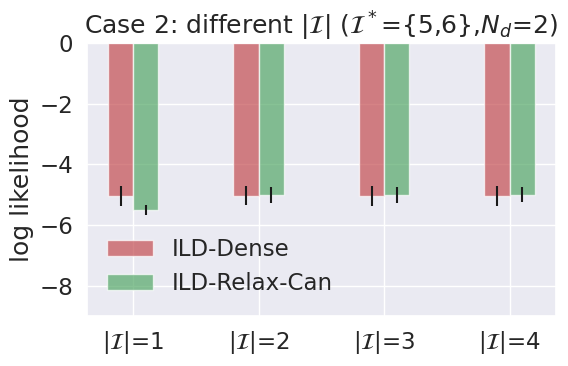

In [60]:

intset = '4,5'
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 6
ndomain = 2
k_spas = [1,2,3,4]


for k_spa in k_spas:
    print(f'Intset = {intset}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best_likelihood(stats_all,specs,candidates)
    display(df)

means = np.zeros((len(k_spas),len(candidates)))
stes = np.zeros((len(k_spas),len(candidates)))

for idx,k_spa in enumerate(k_spas):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa
    
        df = find_best_likelihood(stats_all,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste']
        #stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot_likelihood(means,stes,candidates,len(k_spas),
             ticks=[f'$|\mathcal{{I}}|$={k_spa}' for k_spa in k_spas],
             title=f'Case 2: different $|\mathcal{{I}}|$ ($\mathcal{{I}}^*$={{5,6}},{nt_nd}={ndomain})',
             ticks_rot=rot ,
                        ylim=(-9,0),
            save_dir=f'like_intsizek_ndomain{ndomain}')


# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(5)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ['I={}'.format(intset) for intset in intsets])
# plt.show()


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,3,4,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,-5.680,0.199,0.199,0.629,-6.336,-5.704,-5.943,-6.351,-4.971,-5.803,-6.108,-4.412,-6.170,-5.005
auto_full,-4.841,0.253,0.253,0.801,-5.736,-4.917,-4.880,-5.574,-3.845,-5.019,-5.348,-3.235,-5.702,-4.152


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,-5.186,0.326,0.326,1.031,-5.757,-4.948,-5.393,-5.923,-4.126,-7.048,-5.295,-3.222,-5.845,-4.307
auto_full,-4.842,0.254,0.254,0.803,-5.734,-4.915,-4.880,-5.588,-3.844,-5.348,-5.019,-3.234,-5.701,-4.153


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,-4.870,0.243,0.243,0.769,-5.696,-5.036,-4.843,-5.557,-4.121,-5.379,-4.996,-3.223,-5.690,-4.157
auto_full,-4.846,0.255,0.255,0.806,-5.734,-4.915,-4.878,-5.629,-3.845,-5.348,-5.019,-3.234,-5.702,-4.152


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,-5.194,0.478,0.478,1.511,-5.636,-5.241,-4.884,-8.962,-3.680,-5.369,-5.224,-3.035,-5.742,-4.163
auto_full,-4.841,0.253,0.253,0.801,-5.734,-4.915,-4.880,-5.574,-3.845,-5.348,-5.020,-3.235,-5.701,-4.153


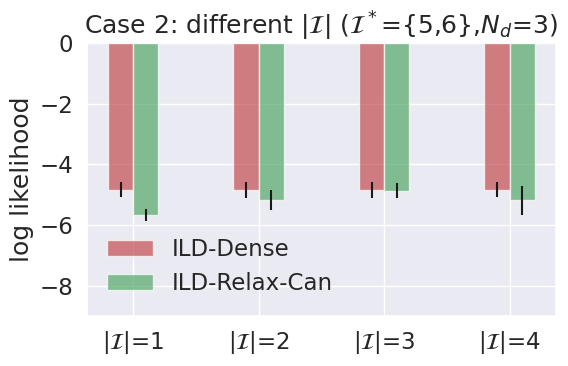

In [61]:

intset = '4,5'
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 6
ndomain = 3
k_spas = [1,2,3,4]


for k_spa in k_spas:
    print(f'Intset = {intset}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best_likelihood(stats_all,specs,candidates)
    display(df)

means = np.zeros((len(k_spas),len(candidates)))
stes = np.zeros((len(k_spas),len(candidates)))

for idx,k_spa in enumerate(k_spas):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa
    
        df = find_best_likelihood(stats_all,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste']
        #stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot_likelihood(means,stes,candidates,len(k_spas),
             ticks=[f'$|\mathcal{{I}}|$={k_spa}' for k_spa in k_spas],
             title=f'Case 2: different $|\mathcal{{I}}|$ ($\mathcal{{I}}^*$={{5,6}},{nt_nd}={ndomain})',
             ticks_rot=rot ,
                        ylim=(-9,0),
            save_dir=f'like_intsizek_ndomain{ndomain}')


# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(5)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ['I={}'.format(intset) for intset in intsets])
# plt.show()


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,-6.055,0.162,0.162,0.513,-6.634,-6.354,-5.920,-6.356,-5.493,-6.314,-6.577,-4.944,-6.293,-5.666
auto_full,-4.965,0.189,0.189,0.596,-5.545,-5.435,-5.045,-4.956,-4.434,-5.432,-5.549,-3.633,-5.212,-4.404


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,-5.084,0.172,0.172,0.543,-5.577,-5.474,-4.759,-5.58,-4.500,-5.436,-5.629,-4.118,-5.338,-4.423
auto_full,-4.964,0.189,0.189,0.596,-5.545,-5.434,-5.045,-4.95,-4.434,-5.432,-5.549,-3.633,-5.212,-4.404


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,-5.198,0.274,0.274,0.868,-5.563,-5.484,-4.994,-7.117,-4.466,-5.439,-5.576,-3.707,-5.233,-4.403
auto_full,-4.965,0.189,0.189,0.596,-5.545,-5.435,-5.045,-4.956,-4.434,-5.432,-5.549,-3.633,-5.212,-4.404


Intset = 4,5


,mean,ste,ste(10),std,9,8,7,6,5,4,3,2,1,0
model,,,,,,,,,,,,,,
auto_true_spa,-5.026,0.177,0.177,0.559,-5.577,-5.433,-5.050,-5.182,-4.538,-5.433,-5.549,-3.864,-5.327,-4.309
auto_full,-4.965,0.189,0.189,0.596,-5.545,-5.435,-5.045,-4.956,-4.434,-5.432,-5.549,-3.633,-5.212,-4.404


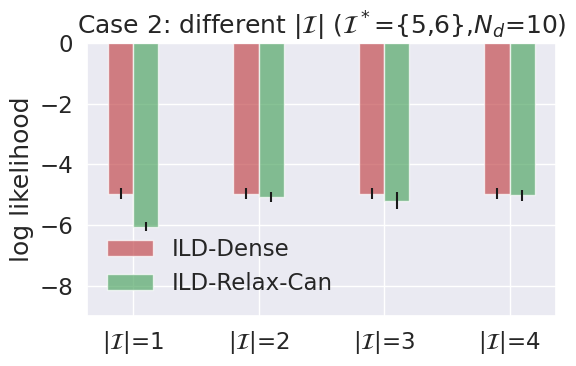

In [62]:

intset = '4,5'
candidates = ['auto_full','auto_true_spa']
scm_idx = '1bl'
latent_dim = 6
ndomain = 10
k_spas = [1,2,3,4]


for k_spa in k_spas:
    print(f'Intset = {intset}')
    specs = {}
    specs['scm_idx'] = scm_idx
    specs['n_domains'] = ndomain
    specs['int_set'] = intset
    specs['latent_dim'] = latent_dim
    specs['k_spa'] = k_spa

    df = find_best_likelihood(stats_all,specs,candidates)
    display(df)

means = np.zeros((len(k_spas),len(candidates)))
stes = np.zeros((len(k_spas),len(candidates)))

for idx,k_spa in enumerate(k_spas):
    for jdx,label in enumerate(candidates):
        specs = {}
        specs['scm_idx'] = scm_idx
        specs['n_domains'] = ndomain
        specs['int_set'] = intset
        specs['latent_dim'] = latent_dim
        specs['k_spa'] = k_spa
    
        df = find_best_likelihood(stats_all,specs,[label])
        means[idx,jdx] = df['mean']
        stes[idx,jdx] = df['ste']
        #stes[idx,jdx] = df['ste(10)']
        
gen_bar_plot_likelihood(means,stes,candidates,len(k_spas),
             ticks=[f'$|\mathcal{{I}}|$={k_spa}' for k_spa in k_spas],
             title=f'Case 2: different $|\mathcal{{I}}|$ ($\mathcal{{I}}^*$={{5,6}},{nt_nd}={ndomain})',
             ticks_rot=rot ,
                        ylim=(-9,0),
            save_dir=f'like_intsizek_ndomain{ndomain}')


# fig, ax = plt.subplots(1,1,figsize=(4,4))
# X = np.arange(5)
# plt.plot(X,(means[:,1]-means[:,3])/means[:,1])
# ax.set_xticks(X+0.25, ['I={}'.format(intset) for intset in intsets])
# plt.show()
